* Do I need the column names?? - If not, then I can just do the encoding/scaling after a little EDA.

Collinearity is an issue.
    * Do heatmap
    * Use either Recursive Feature Selection
    * Or other options in the book

For myself

* Work out how to properly do onehotencoding. Is it possible to fall into the trap zedstatistics mentioned?

* How do you unstandardise the coefficients?

* which method to measure accuracy of model MAE?

* Things to do
    * Check for cutoffs in scatter plots of independent variable
    * Note any extreme values - May need removing from dataset - Done
    * Use stats models to do a simple linear regression and explain the output
    * Check for variables with coefficients close to 0 and p value of the t-statistic greater than 0.05 - This indicates the variables are just offering noise
    * Check the Cond no. a value of 30 indicates multicollinearity, which makes coefficients unstable and limits interpretability of the coefficients
    * Analyse residual plots - Check for non-linearity etc. -Understand what a partial residual is!!
    * Box plot the dependent variable to check for outliers
    * Run linear model without regularization then check distribution of standardised coefficients to determine whether to use Ridge or Lasso
    * Create pipeline - Need experience using it
    * Smartly select features. Explain why the features have been selected

* Visuals
    * heatmap of correlations - Maybe half numbers, half colours?
    * Check for multi-collinearity here - watch zedstats videos again?
    * box plot the categorical variables?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm
from statsmodels.tools import add_constant
%matplotlib inline

In [2]:
df = pd.read_csv('data.csv', index_col=0)

In [3]:
for column in ['body_type', 'condition', 'isTradeSeller', 'make', 'model',
               'transmission', 'location', 'doors', 'manufactured_year', 'seats']:
    df[column] = df[column].astype('category')
    
for column in ['co2Emissions', 'mileage']:
    df[column] = df[column].astype('int64', copy=False)

df.engine_size = df.engine_size.astype('float64')

In [4]:
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4419 entries, 4082 to 3500
Data columns (total 13 columns):
body_type            4419 non-null category
co2Emissions         4419 non-null int64
condition            4419 non-null category
doors                4419 non-null category
engine_size          4419 non-null float64
isTradeSeller        4419 non-null category
make                 4419 non-null category
manufactured_year    4419 non-null category
mileage              4419 non-null int64
model                4419 non-null category
seats                4419 non-null category
transmission         4419 non-null category
location             4419 non-null category
dtypes: category(10), float64(1), int64(2)
memory usage: 200.7 KB


In [6]:
X_train.shape

(4419, 13)

In [7]:
X_train.describe()

,co2Emissions,engine_size,mileage
count,4419.000000,4419.000000,4419.000000
mean,137.525006,1.557343,10667.302105
std,42.300130,0.826792,9018.792879
min,85.000000,0.900000,1.000000
25%,114.000000,1.000000,3971.500000
50%,127.000000,1.400000,8921.000000
75%,148.000000,1.600000,14722.000000
max,464.000000,6.750000,75700.000000


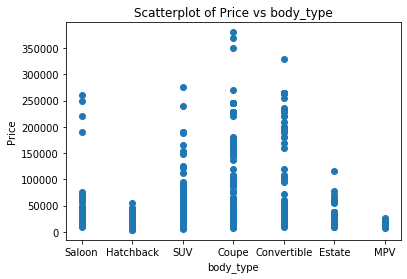

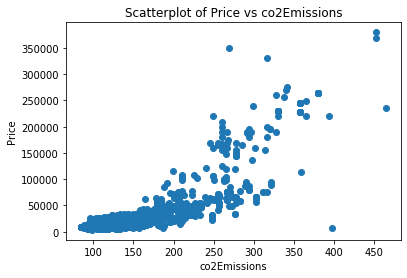

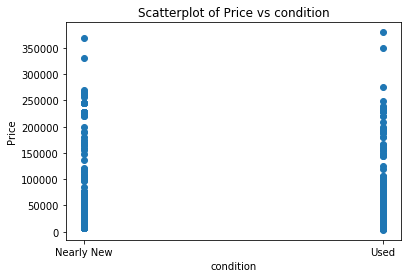

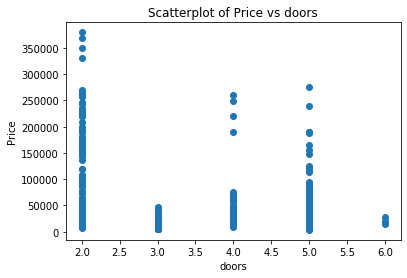

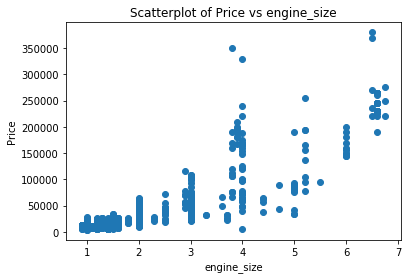

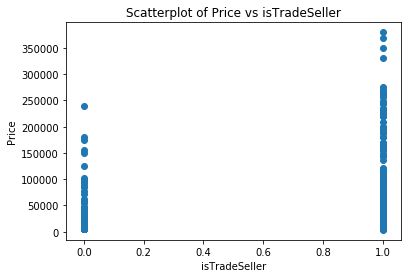

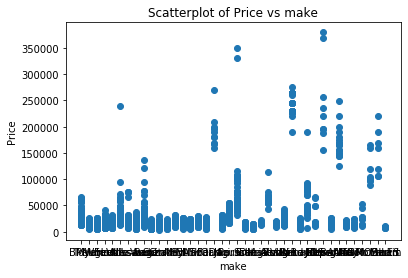

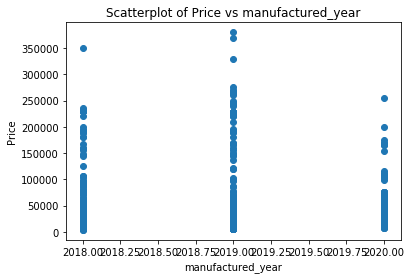

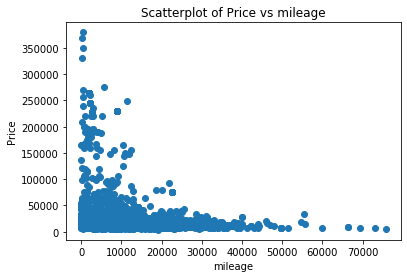

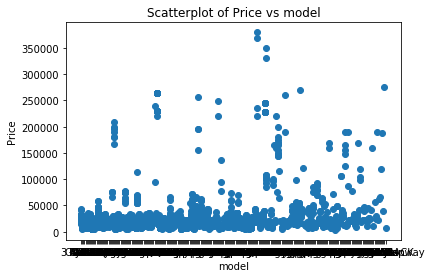

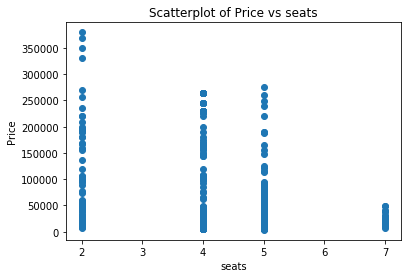

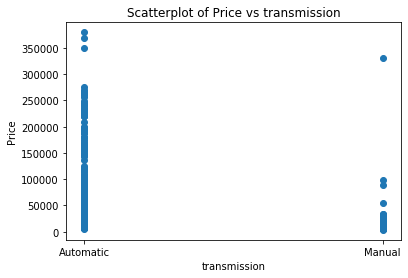

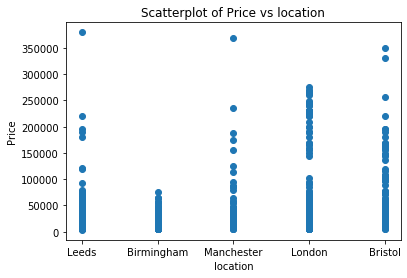

In [8]:
for column in X_train:
    #if (X[column].dtype == 'int64') | (X[column].dtype == 'float64'):
    plt.scatter(X_train[column], y_train)
    plt.xlabel(str(column))
    plt.ylabel("Price")
    plt.title(f"Scatterplot of Price vs {column}")
    plt.show()
    

Whilst scatterplots can be a little misleading in trying to ascertain how independent variables interact with the dependent variable, as it is not possible to view any interactions between independent variables that affect the target. However they can help give an insight into the data.

The plots seem to indicate a non-linear relationship for some variables. So it is worth taking note that a polynomial transformation could lead to a better model.

There appears to be an outlier on the CO2 emissions and transmission plots. This has been noted as something that may need investigating.

Text(0.5, 1.0, 'Histogram of price')

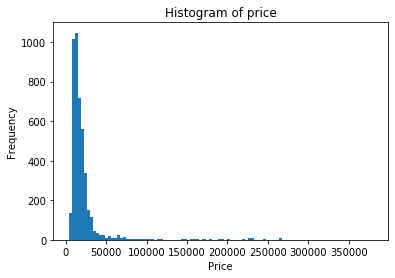

In [22]:
_ = plt.hist(y_train, bins=100)
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Histogram of price")

# Why do this?

In [23]:
#Scale the data to allow for better coefficient interpretation and quicker training
columns_to_scale = ['co2Emissions', 'mileage', 'engine_size']
scaler = StandardScaler()
array_train_columns = scaler.fit_transform(X_train[columns_to_scale])
array_test_columns = scaler.transform(X_test[columns_to_scale])

scaled_train_columns = pd.DataFrame(data=array_train_columns, columns=columns_to_scale)
scaled_test_columns = pd.DataFrame(data=array_test_columns, columns=columns_to_scale)


#Encoding categorical variables
columns_to_encode = ['body_type', 'condition', 'doors', 'isTradeSeller', 'make', 'manufactured_year', 'model', 'seats', 'transmission', 'location']
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
array_encoded_train_columns = ohe.fit_transform(X_train[columns_to_encode])
array_encoded_test_columns = ohe.transform(X_test[columns_to_encode])

#encoded_train_columns = pd.DataFrame(data=array_encoded_train_columns, columns=ohe.get_feature_names())
#encoded_test_columns = pd.DataFrame(data=array_encoded_test_columns, columns=ohe.get_feature_names())


#combine encoded and scaled data

X_train_scaled_encoded = np.concatenate([array_train_columns, array_encoded_train_columns], axis=1)
X_test_scaled_encoded = np.concatenate([array_test_columns, array_encoded_test_columns], axis=1)


In [24]:
#A simple linear model to provide a baseline
X_train_scaled_encoded = add_constant(X_train_scaled_encoded)
X_test_scaled_encoded = add_constant(X_test_scaled_encoded)

stats_linear_model = sm.OLS(y_train, X_train_scaled_encoded)
fitted_stats_model = stats_linear_model.fit()
fitted_stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     650.3
Date:                Tue, 14 Jul 2020   Prob (F-statistic):               0.00
Time:                        07:42:22   Log-Likelihood:                -43371.
No. Observations:                4419   AIC:                         8.735e+04
Df Residuals:                    4116   BIC:                         8.929e+04
Df Model:                         302                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.067e+15   8.86e+15     -0.120      0.904   -1.84e+16    1.63e+16
x1          3524.9192    290.770     12.123      0.000    2954.853    4094.985
x2          -609.9338     94.717     -6.440      0.000    -795.630    -424.238
x3          3149.7354    316.830      9.941      0.000    2528.577    3770.894
x4         -2.268e+14   1.88e+15     -0.120      0.904   -3.92e+15    3.47e+15
x5         -2.268e+14   1.88e+15     -0.120      0.904   -3.92e+15    3.47e+15
x6         -2.268e+14   1.88e+15     -0.120      0.904   -3.92e+15    3.47e+15
x7         -2.268e+14   1.88e+15     -0.120      0.904   -3.92e+15    3.47e+15
x8         -2.154e+14   1.79e+15     -0.120      0.904   -3.72e+15    3.29e+15
x9         -2.268e+14   1.88e+15     -0.120      0.904   -3.92e+15    3.47e+15
x10        -2.268e+14   1.88e+15     -0.120      0.904   -3.92e+15    3.47e+15
x11        -6.909e+14   5.74e+15     -0.120      0.904   -1.19e+16    1.06e+16
x12        -6.909e+14   5.74e+15     -0.120      0.904   -1.19e+16    1.06e+16
x13         3.893e+14   3.23e+15      0.120      0.904   -5.95e+15    6.73e+15
x14         3.893e+14   3.23e+15      0.120      0.904   -5.95e+15    6.73e+15
x15         3.893e+14   3.23e+15      0.120      0.904   -5.95e+15    6.73e+15
x16         3.893e+14   3.23e+15      0.120      0.904   -5.95e+15    6.73e+15
x17         1.221e+14   1.01e+15      0.120      0.904   -1.87e+15    2.11e+15
x18          1.56e+15    1.3e+16      0.120      0.904   -2.38e+16     2.7e+16
x19          1.56e+15    1.3e+16      0.120      0.904   -2.38e+16     2.7e+16
x20        -1.368e+13   1.14e+14     -0.120      0.904   -2.36e+14    2.09e+14
x21        -7.802e+12   6.48e+13     -0.120      0.904   -1.35e+14    1.19e+14
x22         -2.32e+13   1.93e+14     -0.120      0.904   -4.01e+14    3.54e+14
x23        -2.689e+13   2.23e+14     -0.120      0.904   -4.65e+14    4.11e+14
x24        -3.124e+13   2.59e+14     -0.120      0.904    -5.4e+14    4.77e+14
x25         -1.69e+13    1.4e+14     -0.120      0.904   -2.92e+14    2.58e+14
x26        -3.706e+13   3.08e+14     -0.120      0.904   -6.41e+14    5.66e+14
x27           4.1e+12    3.4e+13      0.120      0.904   -6.27e+13    7.09e+13
x28        -2.448e+13   2.03e+14     -0.120      0.904   -4.23e+14    3.74e+14
x29        -2.577e+13   2.14e+14     -0.120      0.904   -4.45e+14    3.94e+14
x30        -1.368e+13   1.14e+14     -0.120      0.904   -2.36e+14    2.09e+14
x31        -2.381e+13   1.98e+14     -0.120      0.904   -4.11e+14    3.64e+14
x32        -1.931e+13    1.6e+14     -0.120      0.904   -3.34e+14    2.95e+14
x33        -3.243e+13   2.69e+14     -0.120      0.904   -5.61e+14    4.96e+14
x34        -2.466e+13   2.05e+14     -0.120      0.904   -4.26e+14    3.77e+14
x35        -2.055e+13   1.71e+14     -0.120      0.904   -3.55e+14    3.14e+14
x3

In [ ]:
residuals = y_train - fitted_stats_model.predict(X_train_scaled_encoded)